In [27]:
'''
  Variational Autoencoder (VAE) with the Keras Functional API.
  adapted from: https://www.machinecurve.com/index.php/2019/12/30/how-to-create-a-variational-autoencoder-with-keras/ (12.12.2021)
'''

import keras
import tensorflow as tf
import tensorflow_probability as tfp
from keras.layers import Input, Flatten, Dense, Lambda, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
tfd = tfp.distributions

In [28]:
# Load MNIST dataset
(input_train, target_train), (input_test, target_test) = mnist.load_data()

In [29]:
tf.compat.v1.disable_eager_execution()

# Data & model configuration
img_width, img_height = input_train.shape[1], input_train.shape[2]
batch_size = 128
no_epochs = 100
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

In [30]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

In [31]:
# # =================
# # Encoder
# # =================

# Definition
i = Input(shape=input_shape, name='encoder_input')
x = Flatten()(i)
x = Dense(256, activation="relu")(x)
x = Dense(256, activation='relu')(x)
mu = Dense(latent_dim, name='latent_mu')(x)
sigma = Dense(latent_dim, name='latent_sigma')(x)

# Define sampling with reparameterization trick
def sample_z(args):
    mu, sigma = args
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    eps = K.random_normal(shape=(batch, dim))
    return mu + K.exp(sigma / 2) * eps


# Use reparameterization trick to ....??
z = Lambda(sample_z, output_shape=(latent_dim,), name='z')([mu, sigma])

# Instantiate encoder
encoder = Model(i, [mu, sigma, z], name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['encoder_input[0][0]']          
                                                                                                  
 dense_10 (Dense)               (None, 256)          200960      ['flatten_2[0][0]']              
                                                                                                  
 dense_11 (Dense)               (None, 256)          65792       ['dense_10[0][0]']               
                                                                                            

In [32]:
# =================
# Decoder
# =================

# Definition
d_i = Input(shape=(latent_dim,), name='decoder_input')
x = keras.layers.Dense(256, activation="relu")(d_i)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dense(784, activation="relu")(x)
o = keras.layers.Reshape(input_shape)(x)

# Instantiate decoder
decoder = Model(d_i, o, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_12 (Dense)            (None, 256)               768       
                                                                 
 dense_13 (Dense)            (None, 256)               65792     
                                                                 
 dense_14 (Dense)            (None, 784)               201488    
                                                                 
 reshape_2 (Reshape)         (None, 28, 28, 1)         0         
                                                                 
Total params: 268,048
Trainable params: 268,048
Non-trainable params: 0
_________________________________________________________________


In [33]:
# =================
# VAE as a whole
# =================

# Instantiate VAE
vae_outputs = decoder(encoder(i)[2])
vae = Model(i, vae_outputs, name='vae')
vae.summary()


Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(None, 2),               267780    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         268048    
                                                                 
Total params: 535,828
Trainable params: 535,828
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Define loss
def kl_reconstruction_loss(true, pred):
    # Reconstruction loss
    reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * img_width * img_height
    # KL divergence loss
    kl_loss = 1 + sigma - K.square(mu) - K.exp(sigma)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    # Total loss = 50% rec + 50% KL divergence loss
    return K.mean(reconstruction_loss + kl_loss)


In [39]:
# Compile VAE
callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
vae.compile(optimizer=opt, loss=kl_reconstruction_loss)

# Train autoencoder
vae.fit(input_train, input_train, epochs=no_epochs, batch_size=batch_size, validation_split=validation_split)

Train on 48000 samples, validate on 12000 samples
Epoch 1/100
48000/48000 [==============================] - 4s 76us/sample - loss: 256.0889 - val_loss: 254.0483
Epoch 2/100
48000/48000 [==============================] - 4s 75us/sample - loss: 252.3048 - val_loss: 255.4599
Epoch 3/100
48000/48000 [==============================] - 4s 76us/sample - loss: 246.0198 - val_loss: 235.1943
Epoch 4/100
48000/48000 [==============================] - 4s 77us/sample - loss: 235.6224 - val_loss: 228.0217
Epoch 5/100
48000/48000 [==============================] - 4s 77us/sample - loss: 232.5632 - val_loss: 242.4292
Epoch 6/100
48000/48000 [==============================] - 4s 77us/sample - loss: 231.2461 - val_loss: 225.1943
Epoch 7/100
48000/48000 [==============================] - 4s 77us/sample - loss: 225.2708 - val_loss: 224.0217
Epoch 8/100
48000/48000 [==============================] - 4s 80us/sample - loss: 225.9049 - val_loss: 245.8018
Epoch 9/100
48000/48000 [=============================

loss = 197

### Subtask 1: What activation functions should be used for the mean and standard deviation of the approximate posterior and the likelihood?

### Subtask 2: What might the reason if we obtain good reconstructed but bad generated digits?

??
When the reconstruction works well but the generation does not, the VAE remembers the training data too well and generalizes bad. The model overfits the given data.

### Subtask 3: Train the VAE

### Subtask 4: Plot the loss curve

In [61]:
#print(vae.history.history)
loss_history = np.array(list(vae.history.history.values())[0])
print(loss_history)

[256.08893107 252.30484631 246.01978918 235.62243945 232.56316093
 231.24611902 225.27082751 225.90492782 235.85152486 229.06483618
 230.08942773 229.85668148 222.24860307 220.90147827 224.73020382
 216.15531779 216.62500228 221.58588997 217.58144364 219.94794194
 219.33514343 215.83944897 223.81020581 220.99108663 216.25127767
 215.89532048 213.0376346  210.91277686 216.35061796 218.65769771
 218.88014351 214.97787256 214.15778312 212.02408191 212.59542741
 209.96107157 210.68906348 213.92920996 214.85114571 213.26527726
 209.71924166 210.73113444 209.24538818 208.05792472 207.14805505
 207.19776363 207.77409603 207.88814551 205.66635718 203.71182007
 205.37611849 204.91675887 204.72910352 203.82813298 203.51730245
 205.51958858 203.10670675 201.84565055 209.23843494 207.68736666
 207.66345203 206.8110804  205.63111523 203.52444084 203.01996179
 207.18683573 203.69944552 201.41570614 204.14959762 205.89058093
 202.94054338 203.00900802 200.66822559 200.37382898 200.48264901
 201.07637

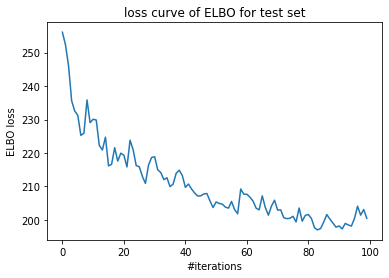

In [63]:
plt.plot(loss_history)
plt.title("loss curve of ELBO for test set")
plt.xlabel('#iterations')
plt.ylabel('ELBO loss')
plt.show()

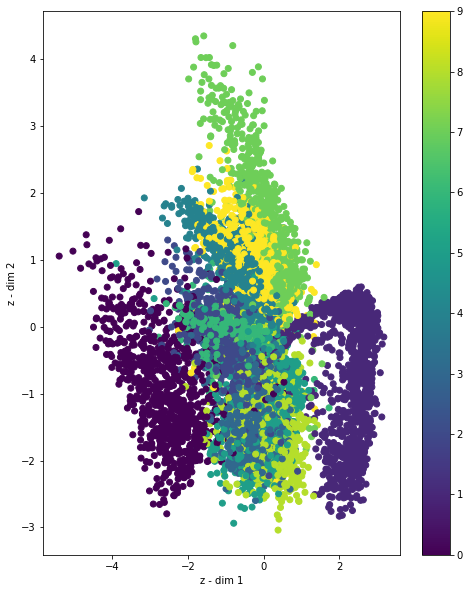

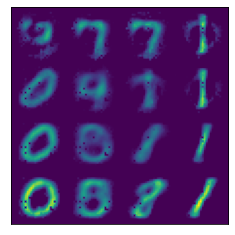

In [70]:
# =================
# Results visualization
# Credits for original visualization code: https://keras.io/examples/variational_autoencoder_deconv/
# (François Chollet).
# Adapted to accomodate this VAE.
# =================
def viz_latent_space(encoder, data):
    input_data, target_data = data
    mu, _, _ = encoder.predict(input_data)
    plt.figure(figsize=(8, 10))
    plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
    plt.xlabel('z - dim 1')
    plt.ylabel('z - dim 2')
    plt.colorbar()
    plt.show()


def viz_decoded(encoder, decoder, data):
    num_samples = 4
    figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
    grid_x = np.linspace(-4, 4, num_samples)
    grid_y = np.linspace(-4, 4, num_samples)[::-1]
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(img_width, img_height, num_channels)
            figure[i * img_width: (i + 1) * img_width,
            j * img_height: (j + 1) * img_height] = digit
    plt.figure(figsize=(4, 4))
    start_range = img_width // 2
    end_range = num_samples * img_width + start_range + 1
    pixel_range = np.arange(start_range, end_range-1, img_width)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)

    plt.xticks([])
    plt.yticks([])
    # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
    # So reshape if necessary
    fig_shape = np.shape(figure)
    if fig_shape[2] == 1:
        figure = figure.reshape((fig_shape[0], fig_shape[1]))
    # Show image
    plt.imshow(figure)
    plt.show()


# Plot results
data = (input_test, target_test)
viz_latent_space(encoder, data)
viz_decoded(encoder, decoder, data)

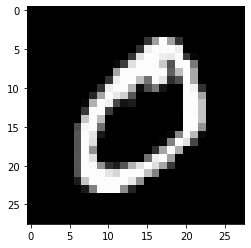

In [41]:
plt.imshow(input_train[1], cmap="gray")

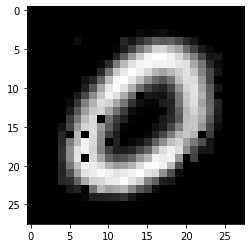

In [42]:
ae_out = vae.predict([input_train[1].reshape(-1, 28, 28, 1) ])
img = ae_out[0]  # predict is done on a vector, and returns a vector, even if its just 1 element, so we still need to grab the 0th
plt.imshow(ae_out[0], cmap="gray")

### Subtask 5: VAE with latent_dim=32

change latent_dim=32 and rerun

Results: